# Project


Colorectal Liver Metastases Recurrence Prediction from Clinical and CT Image Data

# Preliminaries

In [1]:
!nvidia-smi # to see what GPU you have

/bin/bash: nvidia-smi: command not found


In [2]:
!pip install wandb --quiet
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.4 MB/s eta 0:00:00


In [3]:
import torch
from torchsummary import summary
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
import pydicom
import pydicom.data
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cpu


In [4]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

Mounted at /content/drive


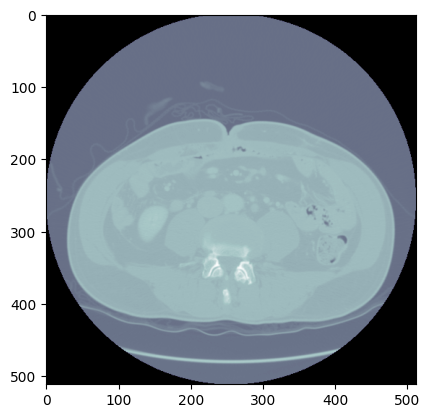

In [ ]:
# Full path of the DICOM file is passed in base
base = r"/content/drive/MyDrive/dataset/Colorectal-Liver-Metastases/CRLM-CT-1001/1.3.6.1.4.1.14519.5.2.1.9203.8273.123231034424011422949554575163/1.3.6.1.4.1.14519.5.2.1.9203.8273.533669585389327696272831671548"
pass_dicom = "1-150.dcm"  # file name is 1-12.dcm
  
# enter DICOM image name for pattern
# result is a list of 1 element
filename = pydicom.data.data_manager.get_files(base, pass_dicom)[0]
  
ds = pydicom.dcmread(filename)
  
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
plt.show()

In [ ]:
import pandas as pd
attributes = pd.read_csv('/content/drive/MyDrive/dataset/attributes.csv')
attributes.columns

Index(['Patient-ID', 'De-identify Scout Name', 'age', 'sex',
       'major_comorbidity', 'chemo_before_liver_resection', 'clinrisk_score',
       'clinrisk_stratified', 'extrahep_disease', 'steatosis_yesno',
       'presence_sinusoidal_dilata', 'NASH_score', 'NASH_yesno',
       'NASH_greater_4', 'total_response_percent', 'necrosis_percent',
       'fibrosis_percent', 'fibrosis_greater_40_percent', 'mucin_percent',
       'overall_survival_months', 'vital_status', 'progression_or_recurrence',
       'months_to_DFS_progression', 'vital_status_DFS',
       'progression_or_recurrence_liveronly',
       'months_to_liver_DFS_progression', 'vital_status_liver_DFS',
       'relevant_notes'],
      dtype='object')

In [ ]:
from random import shuffle
classifier = 'progression_or_recurrence_liveronly'
positive_list = list((attributes.loc[attributes[classifier]==1])['Patient-ID'])
shuffle(positive_list)
negative_list = list((attributes.loc[attributes[classifier]==0])['Patient-ID'])
shuffle(positive_list)
positive_train_list = positive_list[:64]
positive_valid_list = positive_list[64:]
negative_train_list = negative_list[:92]
negative_valid_list = negative_list[92:]
# with open(r'/content/drive/MyDrive/dataset/spilt_list/positive_train.txt', 'w') as fp:
#     for item in positive_train_list:
#         fp.write("%s\n" % item)
#     print('Done')
# with open(r'/content/drive/MyDrive/dataset/spilt_list/positive_valid.txt', 'w') as fp:
#     for item in positive_valid_list:
#         fp.write("%s\n" % item)
#     print('Done')
# with open(r'/content/drive/MyDrive/dataset/spilt_list/negative_train.txt', 'w') as fp:
#     for item in negative_train_list:
#         fp.write("%s\n" % item)
#     print('Done')
# with open(r'/content/drive/MyDrive/dataset/spilt_list/negative_valid.txt', 'w') as fp:
#     for item in negative_valid_list:
#         fp.write("%s\n" % item)
#     print('Done')

In [ ]:
def read_list(path):
  rlist = []
  with open(path) as f:
    lines = f.readlines()
    for line in lines:
      line = line[:-1]
      rlist.append(line)
  return rlist

In [ ]:
positive_train_list = read_list('/content/drive/MyDrive/dataset/spilt_list/positive_train.txt')
positive_valid_list = read_list('/content/drive/MyDrive/dataset/spilt_list/positive_valid.txt')
negative_train_list = read_list('/content/drive/MyDrive/dataset/spilt_list/negative_train.txt')
negative_valid_list = read_list('/content/drive/MyDrive/dataset/spilt_list/negative_valid.txt')

In [ ]:
os.rename('/content/drive/MyDrive/dataset/test/aa.txt','/content/drive/MyDrive/dataset/test/bb.txt')

In [ ]:
def remove_file(old_path, new_path,new_name):
    filelist = os.listdir(old_path)     
    for file in filelist:
        src = os.path.join(old_path, file)
        dst = os.path.join(new_path,new_name+'_'+file)              
        shutil.copyfile(src, dst)

In [ ]:
import shutil, os
os.chdir(r'/content/drive/MyDrive/dataset/')

os.mkdir('/content/drive/MyDrive/dataset/train')
os.mkdir('/content/drive/MyDrive/dataset/valid')
os.mkdir('/content/drive/MyDrive/dataset/train/0')
os.mkdir('/content/drive/MyDrive/dataset/train/1')
os.mkdir('/content/drive/MyDrive/dataset/valid/0')
os.mkdir('/content/drive/MyDrive/dataset/valid/1')



In [ ]:
#for i in positive_train_list:
#  remove_file('/content/drive/MyDrive/dataset/png_data/'+i,'/content/drive/MyDrive/dataset/train/1/',i)
for i in positive_valid_list:
  remove_file('/content/drive/MyDrive/dataset/png_data/'+i,'/content/drive/MyDrive/dataset/valid/1',i)
for i in negative_train_list:
  remove_file('/content/drive/MyDrive/dataset/png_data/'+i,'/content/drive/MyDrive/dataset/train/0/',i)
for i in negative_valid_list:
  remove_file('/content/drive/MyDrive/dataset/png_data/'+i,'/content/drive/MyDrive/dataset/valid/0/',i)

In [ ]:
negative_valid_list

['CRLM-CT-1149',
 'CRLM-CT-1151',
 'CRLM-CT-1152',
 'CRLM-CT-1154',
 'CRLM-CT-1158',
 'CRLM-CT-1159',
 'CRLM-CT-1160',
 'CRLM-CT-1162',
 'CRLM-CT-1163',
 'CRLM-CT-1164',
 'CRLM-CT-1165',
 'CRLM-CT-1167',
 'CRLM-CT-1168',
 'CRLM-CT-1171',
 'CRLM-CT-1172',
 'CRLM-CT-1173',
 'CRLM-CT-1175',
 'CRLM-CT-1177',
 'CRLM-CT-1178',
 'CRLM-CT-1181',
 'CRLM-CT-1182',
 'CRLM-CT-1183',
 'CRLM-CT-1184',
 'CRLM-CT-1188']

In [ ]:
from os.path import exists
exists('/content/drive/MyDrive/dataset/train_whole/1/CRLM-CT-1149_1.png')

In [ ]:
# for i in positive_train_list:
#  remove_file('/content/drive/MyDrive/dataset/png_data/'+i,'/content/drive/MyDrive/dataset/train_whole/1/',i)
# for i in positive_valid_list:
#   remove_file('/content/drive/MyDrive/dataset/png_data/'+i,'/content/drive/MyDrive/dataset/valid_whole/1',i)
# for i in negative_train_list:
#   remove_file('/content/drive/MyDrive/dataset/png_data/'+i,'/content/drive/MyDrive/dataset/train_whole/0/',i)
for i in negative_valid_list:
  remove_file('/content/drive/MyDrive/dataset/png_data/'+i,'/content/drive/MyDrive/dataset/valid_whole/0/',i)

# Configs

In [5]:
config = {
    'batch_size': 8, # Increase this if your GPU can handle it
    'lr': 0.01,
    'epochs': 20, # 10 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Classification Dataset

In [6]:
class DataLoader():
    def __init__(self, dir, batch_size):
        self.dir = dir
        self.batch_size = batch_size
    
    def load(self, train=True):
        
        dataset = torchvision.datasets.ImageFolder(self.dir)

        if train:
            data_loader = torch.utils.data.DataLoader(
                dataset     = dataset, 
                batch_size  = self.batch_size, 
                shuffle     = True,
                num_workers = 4, 
                pin_memory  = True
            )
        else:
            data_loader = torch.utils.data.DataLoader(
                dataset     = dataset, 
                batch_size  = self.batch_size,
                shuffle     = False,
                num_workers = 2
            )
        
        return data_loader

In [7]:
DATA_DIR    = '/content/drive/MyDrive/dataset/'
TRAIN_DIR   = os.path.join(DATA_DIR, "train") 
VAL_DIR     = os.path.join(DATA_DIR, "valid")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html

train_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.RandAugment(6),
    # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0),
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # torchvision.transforms.RandomRotation(10),
    # torchvision.transforms.RandomResizedCrop(224, scale=(0.7,1)),
    # torchvision.transforms.RandomGrayscale(p=0.1),
    #torchvision.transforms.Resize(224),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.512,0.403,0.352], std=[0.271,0.236,0.223]),
])

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(224),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.512,0.403,0.352], std=[0.271,0.236,0.223])
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?


# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 4, 
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset, 
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

In [ ]:
for i, (images, labels) in enumerate(train_loader):
  print(images.shape)
  break

torch.Size([8, 1, 224, 224])


In [ ]:
mean=[0,0,0]
std=[0,0,0]
n = len(train_dataset)
for i in train_dataset :
  mean[0] += torch.mean(i[0][0,:,:])
  mean[1] += torch.mean(i[0][1,:,:])
  mean[2] += torch.mean(i[0][2,:,:])
  std[0] += torch.std(i[0][0,:,:])
  std[1] += torch.std(i[0][1,:,:])
  std[2] += torch.std(i[0][2,:,:])


KeyboardInterrupt: ignored

In [ ]:
print(np.array(mean)/n)

[0.51160664 0.4026156  0.35185954]


In [ ]:
print(np.array(std)/n)

[0.2710012  0.23619609 0.22259819]


In [ ]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  2
No. of train images  :  13665
Shape of image       :  torch.Size([1, 224, 224])
Batch size           :  8
Train batches        :  1709
Val batches          :  498


# Very Simple Network (for Mandatory Early Submission)

In [ ]:
# Reference: https://arxiv.org/abs/2201.03545(github: https://github.com/facebookresearch/ConvNeXt) 
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.bn1 = nn.BatchNorm2d(dim)
        self.conv2 = nn.Conv2d(dim, dim*4, kernel_size= 1, stride= 1, padding= 0)
        self.gelu = nn.GELU()
        self.conv3 = nn.Conv2d(4*dim, dim, kernel_size= 1, stride= 1, padding= 0)
    
    def forward(self, x):
        self.input = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.gelu(x)
        x = self.conv3(x)
        return x + self.input
    
class ConvNeXt_L(nn.Module):
    def __init__(self, in_channels= 1, num_class= 2, depths= [3, 3, 27, 3], dims = [192, 384, 768, 1536]):
        super().__init__()
        self.downsample_layers = nn.ModuleList()
        self.stage_layers = nn.ModuleList()
        self.cls_layer = nn.Linear(dims[-1], num_class)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flat = nn.Flatten()
        self.dropout = nn.Dropout(p = 0.3)
        
        # add stem layer
        self.stem_layer = nn.Sequential(
            nn.Conv2d(in_channels, dims[0], kernel_size= 4, stride= 4),
            # use BN rather than LN, which is different from the original model
            nn.BatchNorm2d(dims[0])
        )
        self.downsample_layers.append(self.stem_layer)
        
        # add different down-sample layer 
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.BatchNorm2d(dims[i]),
                nn.Conv2d(dims[i], dims[i+1], kernel_size= 2, stride= 2)
            )
            self.downsample_layers.append(downsample_layer)
            
        # add model block to stage layer
        for i in range(4):
            stage_layer = nn.Sequential(
                *[Block(dim= dims[i]) for k in range(depths[i])]
            )
            self.stage_layers.append(stage_layer)
        
    def forward(self, x, return_feats=False):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stage_layers[i](x)
        x = self.avgpool(x)
        x = self.flat(x)
        x = self.dropout(x)

        return self.cls_layer(x)

In [ ]:
model = ConvNeXt_L().to(DEVICE)
summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 192, 128, 128]           3,264
            Conv2d-2        [-1, 192, 128, 128]           3,264
       BatchNorm2d-3        [-1, 192, 128, 128]             384
       BatchNorm2d-4        [-1, 192, 128, 128]             384
            Conv2d-5        [-1, 192, 128, 128]           9,600
       BatchNorm2d-6        [-1, 192, 128, 128]             384
            Conv2d-7        [-1, 768, 128, 128]         148,224
              GELU-8        [-1, 768, 128, 128]               0
            Conv2d-9        [-1, 192, 128, 128]         147,648
            Block-10        [-1, 192, 128, 128]               0
           Conv2d-11        [-1, 192, 128, 128]           9,600
      BatchNorm2d-12        [-1, 192, 128, 128]             384
           Conv2d-13        [-1, 768, 128, 128]         148,224
             GELU-14        [-1, 768, 1

In [ ]:
import torch.nn as nn
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=2):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

In [ ]:
def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])
model = resnet18().to(DEVICE)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
        BasicBlock-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14         [-1, 64, 2

# Setup everything for training

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 89.0 MB/s eta 0:00:00


In [ ]:
import transformers

In [ ]:
#criterion = torch.nn.CrossEntropyLoss(
#    label_smoothing=0.5
#    )# TODO: What loss do you need for a multi class classification problem?
criterion = torch.nn.CrossEntropyLoss()
#torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * config['epochs']))

#num_training_steps = len(train_loader) * config['epochs']
#num_warmup_steps = int(num_training_steps * 0.1)
#scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles= 0.5)
# TODO: Implement a scheduler (Optional but Highly Recommended)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V1


# Let's train!

In [ ]:
def train(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() 

        scheduler.step()
        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="446a558e8eb0a38f75fdb013d422df4241ea9a9f") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "try-conv-base-4", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "ml-proj", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

learning_Rate,▁
train_Acc,▁
train_loss,▁
validation_Acc,▁
validation_loss,▁
learning_Rate,0.00994
train_Acc,8.03101
train_loss,0.02093
validation_Acc,7.58032
validation_loss,4.54653


# Experiments

In [ ]:
best_valacc = 0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss = validate(model, valid_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
               'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently 

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc, 
                  'epoch': epoch}, '/content/drive/MyDrive/mlproj_base1.pth')
      best_valacc = val_acc
      wandb.save('checkpoint.pth')
      # You may find it interesting to exlplore Wandb Artifcats to version your models
run.finish()


Epoch 1/20: 
Train Acc 7.2557%	 Train Loss 0.2916	 Learning Rate 0.0100


Val Acc 10.4418%	 Val Loss 4.1778
Saving model



Epoch 2/20: 
Train Acc 7.3215%	 Train Loss 0.0221	 Learning Rate 0.0099


Val Acc 11.4458%	 Val Loss 4.8773
Saving model



Epoch 3/20: 
Train Acc 7.3874%	 Train Loss 0.0018	 Learning Rate 0.0098


Val Acc 12.0482%	 Val Loss 4.9220
Saving model



Epoch 4/20: 
Train Acc 7.2411%	 Train Loss 0.0027	 Learning Rate 0.0095


Val Acc 9.0361%	 Val Loss 5.9449



Epoch 5/20: 
Train Acc 7.5629%	 Train Loss 0.0000	 Learning Rate 0.0090


Val Acc 9.0361%	 Val Loss 5.9029



Epoch 6/20: 
Train Acc 7.9067%	 Train Loss 0.0000	 Learning Rate 0.0085


Val Acc 9.0361%	 Val Loss 5.7536



Epoch 7/20: 
Train Acc 7.3362%	 Train Loss 0.0000	 Learning Rate 0.0079


Val Acc 9.0361%	 Val Loss 5.6239



Epoch 8/20: 
Train Acc 6.9412%	 Train Loss 0.0000	 Learning Rate 0.0073


Val Acc 8.8353%	 Val Loss 5.7124



Epoch 9/20: 
Train Acc 7.1460%	 Train Loss 0.0000	 Learning Rate 0.0065


Val Acc 8.8353%	 Val Loss 5.5489



Epoch 10/20: 
Train Acc 6.9412%	 Train Loss 0.0000	 Learning Rate 0.0058


Val Acc 8.6345%	 Val Loss 5.8079



Epoch 11/20: 
Train Acc 6.5170%	 Train Loss 0.0000	 Learning Rate 0.0050


Val Acc 9.0361%	 Val Loss 5.7744


Train:  50%|█████     | 858/1709 [13:25<13:22,  1.06it/s, acc=7.5758%, loss=0.0000, lr=0.0038, num_correct=520]

FileNotFoundError: ignored

# Classification Task: Testing

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  
  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)
      
      batch_bar.update()
      
  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

## Generate csv to submit to Kaggle

In [ ]:
with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(5) + ".jpg", test_results[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-classification -f classification_early_submission.csv -m "early submission"

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites 
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities. 

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s23-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6) 

In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'): 

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size
        
        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model         
        unknown_feats.append(unknown_feat)
        batch_bar.update()
    
    batch_bar.close()
    
    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    
    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size] 
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)
          
        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain 
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings
    
    # After early submission, remove the previous line and uncomment the following code 

    # threshold = # Choose a proper threshold
    # NO_CORRESPONDENCE_LABEL = 'n000000'
    # pred_id_strings = []
    # for idx, prediction in enumerate(predictions):
    #     if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
    #         pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
    #     else:
    #         pred_id_strings.append(known_paths[prediction])
    
    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s23-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
    
    return pred_id_strings

In [ ]:
# verification eval
pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
# verification test
pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

In [ ]:
# add your finetune/retrain code here

## Generate csv to submit to Kaggle

In [ ]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-verification -f verification_early_submission.csv -m "early submission"